# Neural Ordinary Differential Equation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint

import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.express as px

## 0. Dataset

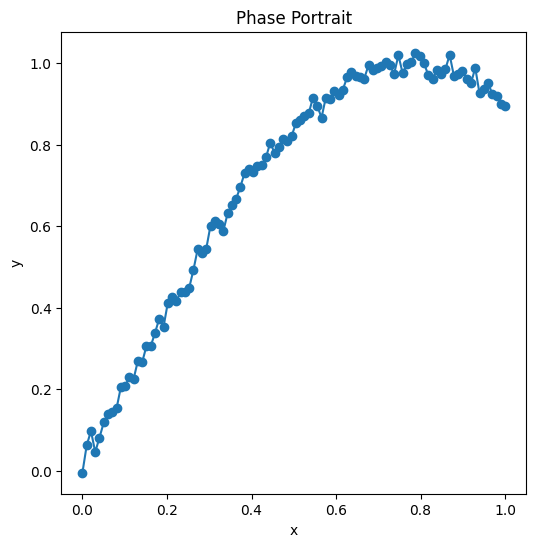

In [21]:
data_size = 100
x = torch.linspace(0., 1., data_size)
y = torch.sin(2*x)

noise = torch.normal(0, 0.02, size=(data_size,)) 
y = y + noise


fig = plt.figure(figsize=(6, 6), facecolor='white')
ax = fig.add_subplot(111) 
ax.set_title('Phase Portrait')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(x, y, label='', marker='o')

In [22]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# data_standard_scaler = StandardScaler()
# data_stand = data_standard_scaler.fit_transform(data)
# data_stand[:3]
# data = data_stand

x = x.clone().detach().unsqueeze(1).float()
y = y.clone().detach().unsqueeze(1).float()

In [23]:
indices = torch.randperm(data_size)
x = x[indices]
y = y[indices]

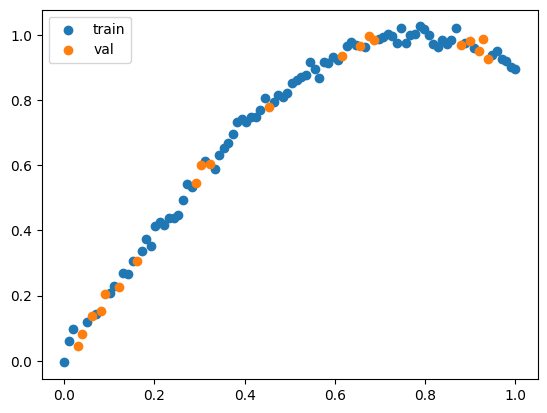

In [24]:
# Train/validation split
split_index = int(data_size * 0.8)

train_data = {
    'input': x[:split_index].unsqueeze(1),
    'target': y[:split_index].unsqueeze(1)
}

val_data = {
    'input': x[split_index:].unsqueeze(1),
    'target': y[split_index:].unsqueeze(1)
}

plt.figure()
plt.scatter(
    x=train_data['input'][:, 0, 0], 
    y=train_data['target'][:, 0, 0], 
    label='train', marker='o'
)
plt.scatter(
    x=val_data['input'][:, 0, 0], 
    y=val_data['target'][:, 0, 0], 
    label='val', marker='o'
)
plt.legend()
plt.show()

In [25]:
batch_time = 5
batch_size = 8
train_data_size = train_data['input'].shape[0]

def get_batches(data, batch_size):
    
    data_size = data['input'].shape[0]
    batches = []  
    
    for i in range(0, data_size - batch_time, batch_size):
                                  
        if i + batch_size > data_size: 
            break
                                
        batch_y0 = data['input'][i:i+batch_size] 
        # batch_t = torch.linspace(0, 1, steps=batch_time)
        batch_y = data['target'][i:i+batch_size]  
        batches.append((batch_y0, batch_y))

    return batches

batches =  get_batches(train_data, batch_size)

## 3. Neural ODE 

Реализуем сопряженное обратное распространение c использованием пакет torchdiffeq.

Обратное распространение через odeint осуществляется через внутренние компоненты решателя. 

```
from torchdiffeq import odeint_adjoint as odeint
odeint_adjoint(func, y0, t, rtol, atol, method)
```

In [26]:
class ODEfunc(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 150)
        self.tanh1 = nn.Tanh()
        self.lin2 = nn.Linear(150, 1)
        
        # for m in self.net.modules():
            # if isinstance(m, nn.Linear):
                # nn.init.normal_(m.weight, mean=0, std=0.1)
                # nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
        x = self.lin1(x)
        x = self.tanh1(x)
        x = self.lin2(x)
        return x

class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc

    def forward(self, x):
        integration_time = torch.tensor([0, 1]).float()
        out = odeint_adjoint(func=self.odefunc, y0=x, t=integration_time,rtol=1e-7, atol=1e-9, method='dopri5')
        return out[1]

class ODENet(nn.Module):
    def __init__(self):
        super(ODENet, self).__init__()
        self.ode_block = ODEBlock(ODEfunc())

    def forward(self, x):
        x = self.ode_block(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

model = ODENet().to(device)

In [27]:
def visualize():
    plt.figure()
    plt.scatter(x=train_data['input'][:, 0, 0], y=train_data['target'][:, 0, 0], label='train', marker='o')
    plt.scatter(x=val_data['input'][:, 0, 0], y=val_data['target'][:, 0, 0], label='val', marker='o')
    plt.scatter(x=train_data['input'][:, 0, 0], y=pred_y_train.detach().numpy()[:, 0, 0], label='pred train', marker='o')
    plt.scatter(x=val_data['input'][:, 0, 0], y=pred_y_val.detach().numpy()[:, 0, 0], label='pred train', marker='o')
    plt.legend()
    plt.show()

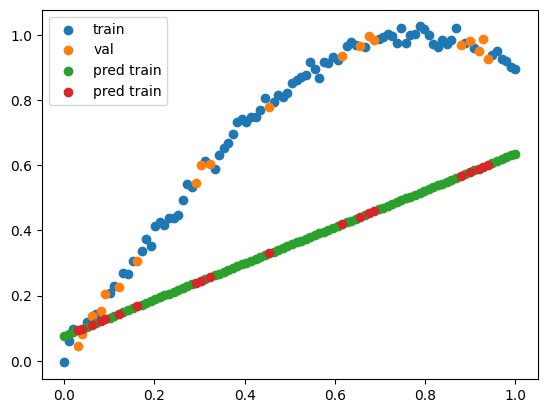

In [28]:
pred_y_train = model(train_data['input'].to(device))
pred_y_val = model(val_data['input'].to(device))

visualize()

  0%|          | 0/2001 [00:00<?, ?it/s]

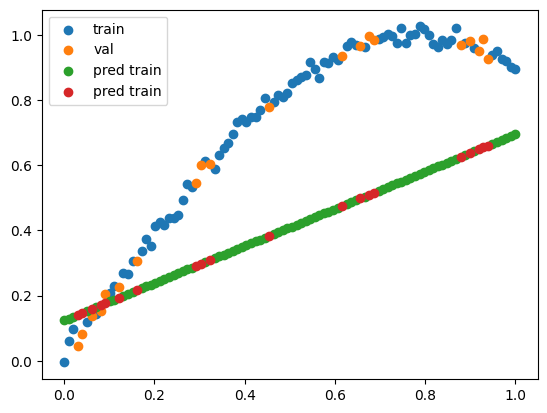

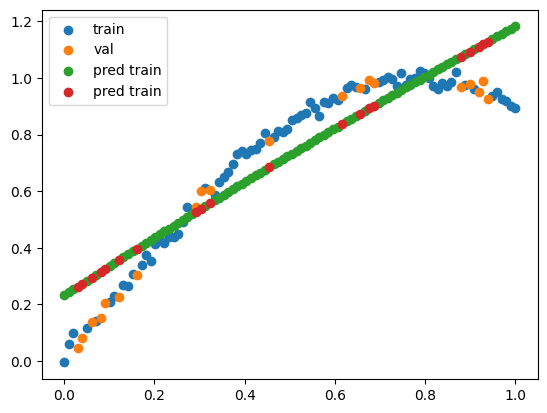

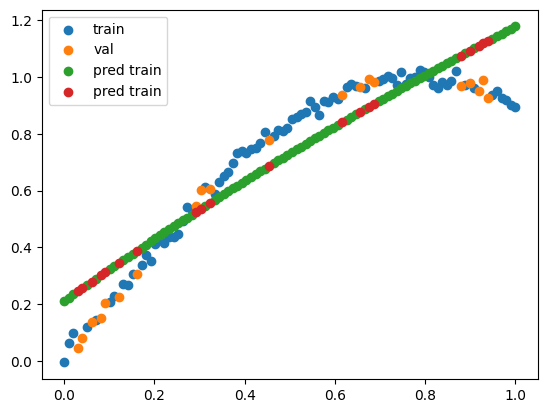

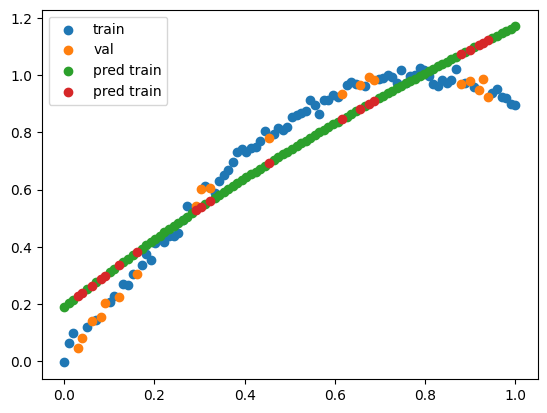

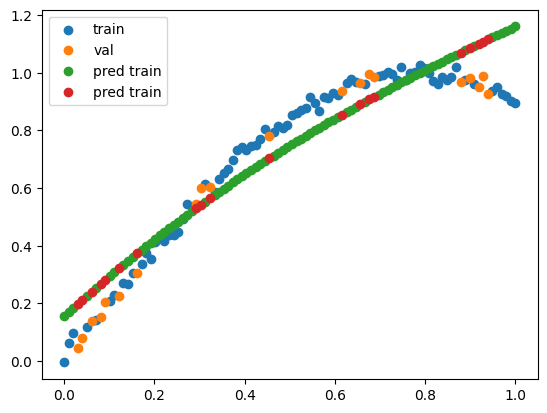

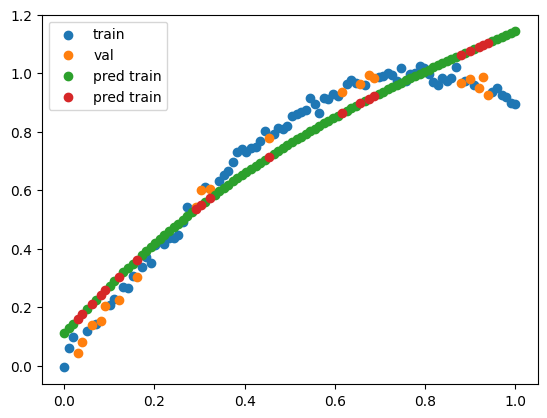

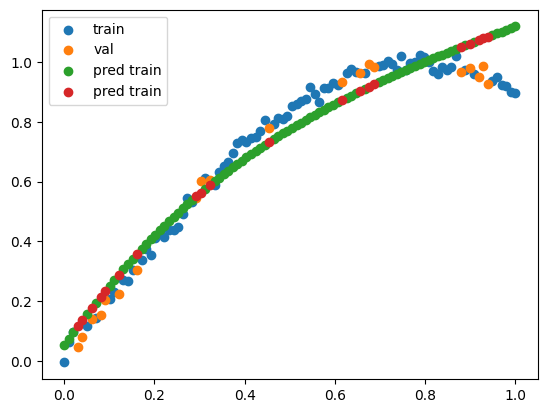

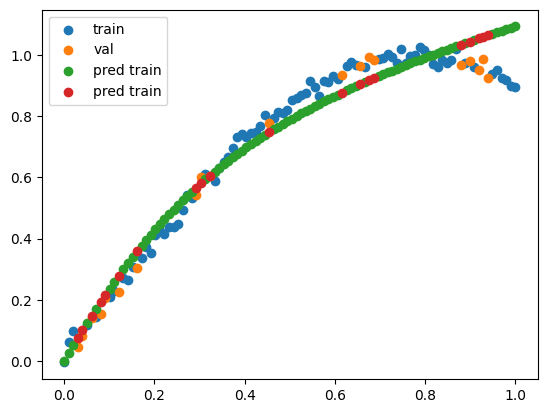

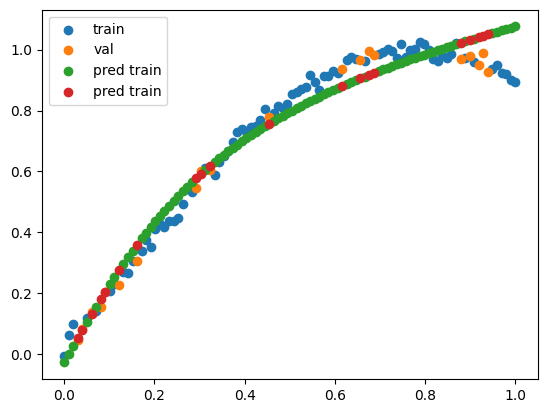

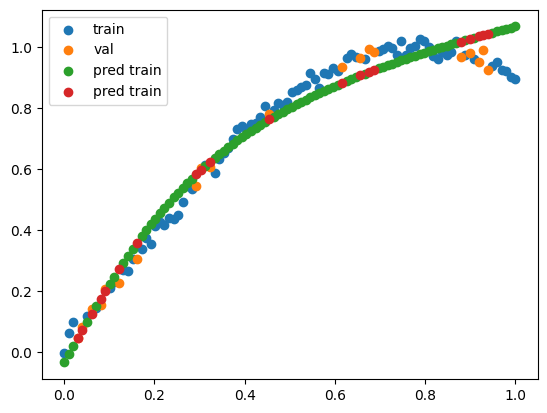

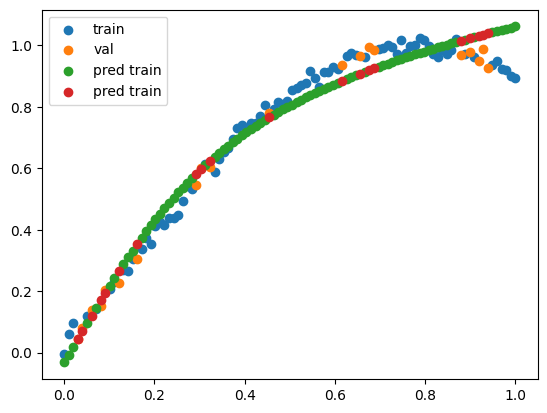

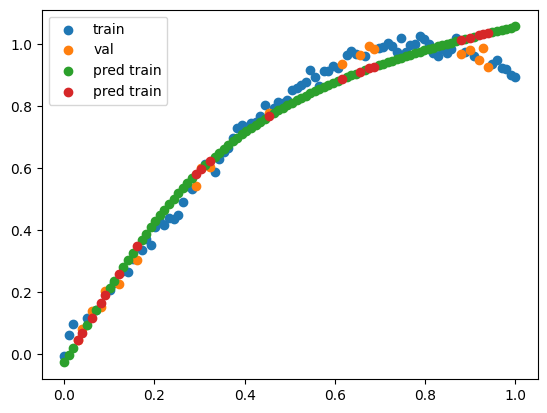

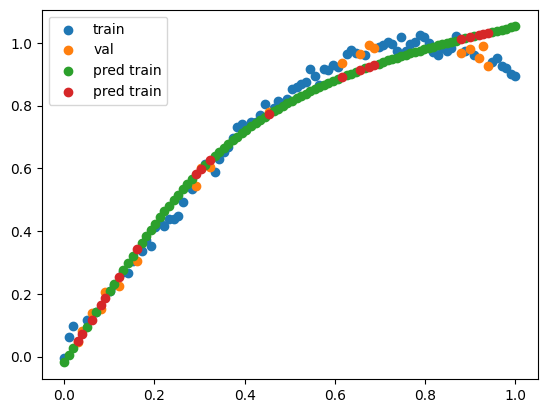

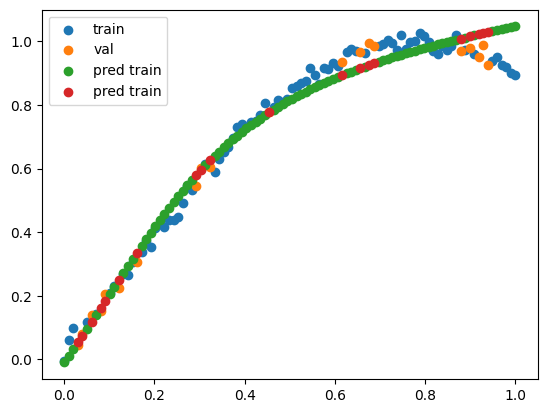

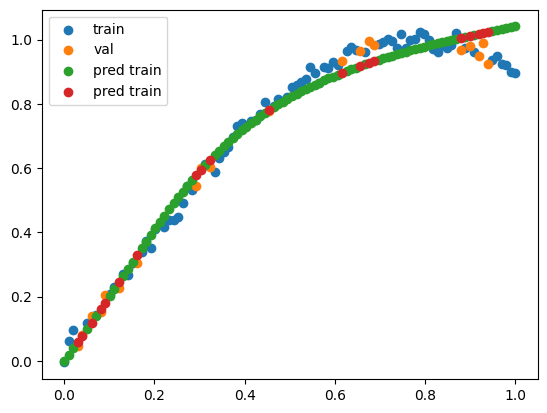

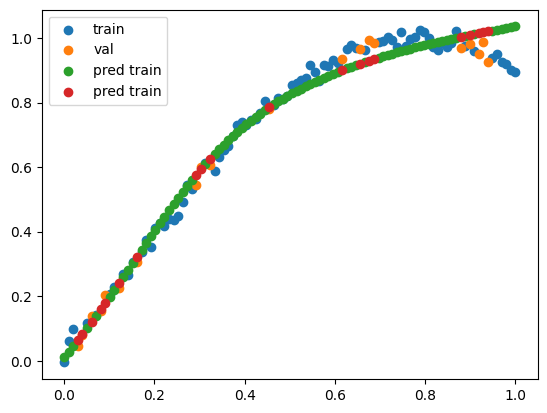

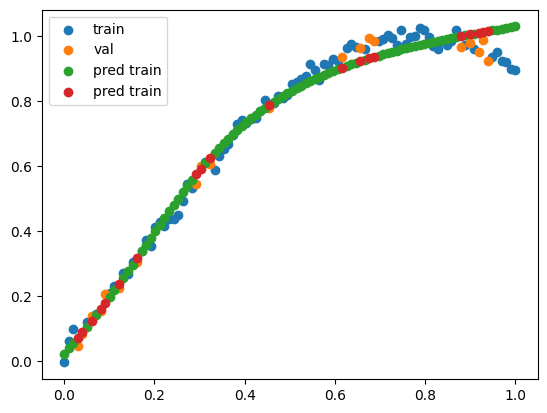

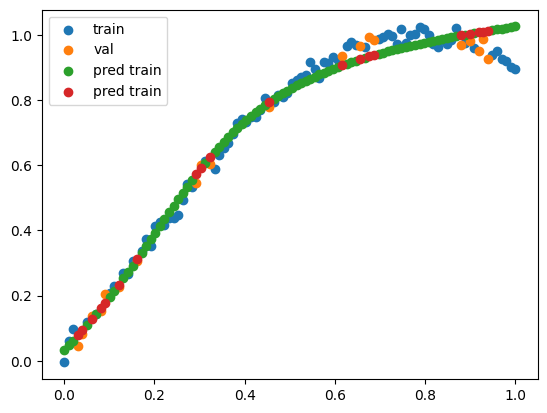

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

hist_train_loss = []
hist_val_loss = []

for epoch in tqdm(range(2000+1)):
    # train
    model.train()
    optimizer.zero_grad() 
    loss = 0
    for batch_idx, (batch_y0, batch_y) in enumerate(batches):  
        batch_y0, batch_y = batch_y0.to(device), batch_y.to(device)
        pred_y = model(batch_y0)
        # print(pred_y)
        # loss += criterion(pred_y, batch_y)
        # loss += torch.mean(torch.abs(pred_y - batch_y))
        loss += criterion(pred_y, batch_y)
    loss.backward()
    optimizer.step()
    hist_train_loss.append(loss.item())
    
    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        pred_y = model(val_data['input'].to(device))
        val_loss += criterion(pred_y, val_data['target'].to(device))
        hist_val_loss.append(val_loss.item())
    
    if epoch % 100 == 0:
        pred_y_train = model(train_data['input'].to(device))
        pred_y_val = model(val_data['input'].to(device))
        visualize()
        

## 